In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import math
from astropy.io import fits
from operator import sub
from scipy import optimize
from itertools import zip_longest
import matplotlib.animation as animation
import sys

In [2]:
#global variables
nchannels = 0
basis_funcs = []

In [3]:
def animate(img):
    fig = plt.figure()

    imlist = []
    for i in range(len(em[0, 0, :])):
        image = em[:,:,i]
        im = plt.imshow(image, animated = True, cmap = 'jet', vmin=0, vmax=np.max(em))
        imlist.append([im])
    ani = animation.ArtistAnimation(fig, imlist, interval = 20, blit = True)
    plt.show()

In [4]:
def response(resp, lgt):
    suvi_labels=[r'$94\,\,\AA$',r'$131\,\,\AA$',r'$171\,\,\AA$',r'$195\,\,\AA$', r'$284\,\,\AA$', r'$304\,\,\AA$']

    fig,ax = plt.subplots(figsize=(10, 8))

    ax.plot(lgt, resp[0], linewidth=2, linestyle = '-', label = suvi_labels[0])
    ax.plot(lgt, resp[2], linewidth=2, linestyle = '-', label = suvi_labels[2])

    #set plot options
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([4, 8])
    ax.set_ylim([1e-33, 1e-26])

    #labels
    ax.set_xlabel(r'$Log{T}\,\,\mathrm{(K)}$', fontsize = 22)
    ax.set_ylabel(r'Temperature Response $(\mathrm{DN}\,\mathrm{cm}^{-5}\,\mathrm{pix}^{-1})$', fontsize=22)
    
    #legend
    ax.legend(loc='best', fontsize=14)

    plt.tight_layout()
    plt.show()

In [5]:
def linear_alg(resp, lgtaxis):
    global nchannels
    global basis_funcs
    np.set_printoptions(threshold = sys.maxsize) ## replace np.nan, by vlslv on Dec 12, 2019 
    basis_sigmas = [0, 0.1, 0.2] 
    rnge = lgtaxis[1]-lgtaxis[0]
    emunit = 1e27
    basis_funcs = np.zeros((len(lgtaxis), len(basis_sigmas)*len(lgtaxis)))
    for i in range(len(basis_sigmas)):
        if basis_sigmas[i] == 0:
            np.fill_diagonal(basis_funcs, 1.0)
        else:
            ext = list(map(lambda x: x*rnge, range(-25, 25)))
            line = list(map(lambda x: math.exp(x/basis_sigmas[i])**2, ext))
            cut = np.argwhere(np.array(line) < 0.04)
            for j in cut:
                line[j[0]] = 0.0
            norm = sum(line)
            for j in range(len(lgtaxis)):
                line = list(map(lambda x: math.exp(-((x-lgtaxis[j])/basis_sigmas[i])**2.0), lgtaxis))
                cut = np.argwhere(np.array(line) < 0.04)
                for k in cut:
                    line[k[0]] = 0.0
                basis_funcs[0:len(lgtaxis), len(lgtaxis)*i + j] = line
    if len(resp) > 0:
        nchannels = resp[0].size
        Dict = np.matmul(np.matrix.transpose(basis_funcs), resp)
        Dict *= 1e26
        return(Dict)
    return             

In [6]:
def DEM_solve(img, Dict, lgtaxis, tolfac, locations):
    global basis_funcs

    eps = 1e-3
    relax = 1
    symmbuff = 1.0
    adaptive_tolfac = 1
    dim = np.array(img).shape
    print(dim)
    NOCOUNTS = np.where(np.array(np.array(img).sum(axis=0)) < 10*eps) #flagged

    ntemp = len(Dict[:,0])
    coeffs = np.zeros((dim[2], dim[1], ntemp))
    print(coeffs.shape)
    zmax = np.zeros((dim[2], dim[1]))
    status = np.zeros((dim[2], dim[1]))
    tolmap = np.zeros((dim[2], dim[1]))

    zequation = np.zeros(ntemp) #63 elements
    zequation[:] = 1.0 #simplex in idl is a MINIMIZATION not maximization so the zequation is all +1.0 not -1.0

    constraint = np.zeros((ntemp, 8)) # [8 63]
    constraint[0:ntemp, 0:4] = Dict # row 1-64 and columns 0-4
    constraint[0:ntemp, 4:8] = -Dict # row 1-64 and columns 5-8
    constraint = np.transpose(constraint)
    B = np.zeros(8)
    nimg = np.empty((1280, 1280, 4))

    X, Y = np.meshgrid(np.arange(-int(len(img[0,:,0]))/2, int(len(img[0,0,:])/2)), 
                       np.arange(-int(len(img[0,:,0]))/2, int(len(img[0,0,:])/2))) 
    xsi, ysi = np.where(np.hypot(X,Y) < 50)
    xyzip = list(zip_longest(xsi, ysi))
    for i, j in xyzip:
            
            temp = []
            tol = []
            for k in range(4):
               if img[k][i][j] < 0:
                   temp.append(0)
               else:
                   temp.append(img[k][i][j])
            for k in temp:
               if k > 1.0:
                   tol.append(tolfac*0.8*math.sqrt(k))
               else:
                   tol.append(tolfac*0.8)

            B[0:4] = [a+b for a, b in zip(tol, temp)]
            B[4:8] = list(map(lambda x: -x if x > 0 else 0,  map(sub, temp, tol)))
            
            res = scipy.optimize.linprog(zequation,
                                         A_ub = constraint,
                                         b_ub = B,
                                         options = {'tol': eps*np.max(temp)*8e-4})

            coeff = res.x
            soln = -res.fun

            if isinstance(coeff, float): #if nan 
                new = [0]*ntemp
                s = 10
            else: # successfully provided a list
                new = [soln] + coeff.tolist()
                s = res.status
                nimg[i,j,:] = np.matmul(np.asmatrix(Dict).T, np.asmatrix(coeff).T).flatten()

            # if one of the new solutions is less than zero
            # make all zero, otherwise keep them
            # if nan befor or < 0 flags as unsuccessful
            if min(new[1:]) < 0:
                coeffs[i][j][0:ntemp] = 0.0
                s = 10
            else:
                coeffs[i][j][0:ntemp-1] = new[1:ntemp]

            zmax[i][j] = new[0]
            status[i][j] = s
    
    if len(NOCOUNTS[0]) != 0:
        status[NOCOUNTS] = 11.0
        for i in range(len(lgtaxis)):
            coeffsnew = np.squeeze(coeffs[:,:,i])
            coeffsnew[NOCOUNTS] = 0.0
            coeffs[:,:,i] = coeffsnew
    oem = np.zeros((dim[1], dim[2], len(lgtaxis)))
    for i, j in xyzip:
          oem[i, j, :] = np.squeeze(np.matmul(np.squeeze(coeffs[i, j, :]), np.transpose(basis_funcs)))
    print(oem.shape)
    img = np.array(img)  
    bad = np.where(status != 0)
    badimg = np.reshape(img, (dim[1]*dim[2], 1, len(img[:, 0, 0])))[bad, 0 , :] 
    newtolfac = 1.5*tolfac
    return(oem, nimg)

############ Main ############

In [7]:
demdata = pd.read_csv('suvi_trf_rad.txt', delimiter = ' \t ', engine = "python")
print(demdata.keys())
demdata.columns = [0, 1, 2, 3, 4, 5, 6] #reassigns the column titles by their indicies 
print(demdata.keys())

Index(['# Temperature (K)', '94', '131', '171', '195', '284', '304'], dtype='object')
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')


In [8]:
lgt=list(map(lambda x: np.log10(x), list(demdata[0][x] for x in list(map(lambda x: x*4 + 72, np.arange(0,21)))))) 

graphing SUVI response functions


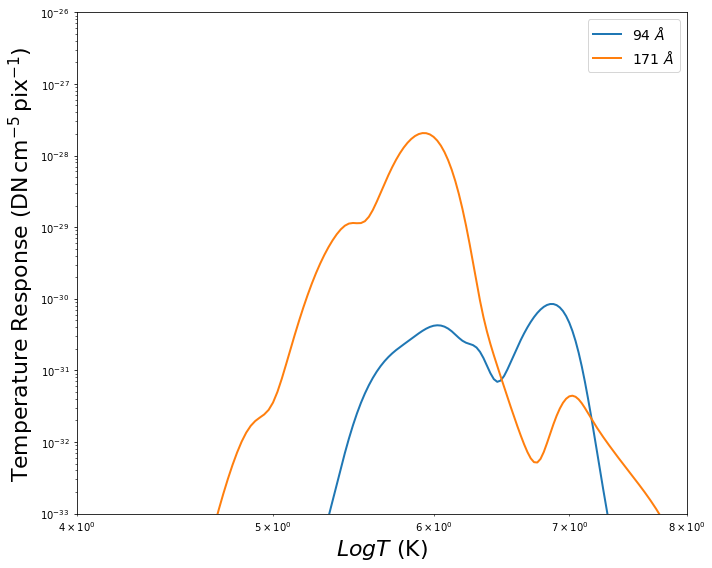

In [9]:
print('graphing SUVI response functions')
response([demdata[1].tolist(),
          demdata[2].tolist(), 
          demdata[3].tolist(), 
          demdata[4].tolist(), 
          demdata[5].tolist(), 
          demdata[6].tolist()],list(map(lambda x: np.log10(x), demdata[0]))) 

In [10]:
resp = np.zeros((21, 4))
for i in range(4): 
    for x, j in zip(list(map(lambda x: x*4 + 72, np.arange(0, 21))),  range(21)):
        resp[j][i] = demdata[demdata.columns[i+1]][x]*100 #not sure if necessary

In [11]:
locations = 0
Dict = linear_alg(resp, lgt) # [63, 4] matrix

In [12]:
img94  = fits.open('SUVI_Composite_094_2017_09_10.fits')
img131 = fits.open('SUVI_Composite_131_2017_09_10.fits')
img171 = fits.open('SUVI_Composite_171_2017_09_10.fits')
img195 = fits.open('SUVI_Composite_195_2017_09_10.fits')

In [13]:
img = np.array([img94[0].data*100, img131[0].data*100, img171[0].data*100, img195[0].data*100])

In [14]:
tolfac = 0.1 # originaly 1.4
em, nimg  = DEM_solve(img, Dict, lgt, tolfac, locations)

(4, 1280, 1280)
(1280, 1280, 63)
(1280, 1280, 21)


In [19]:
wide,height,layer = np.shape(nimg)

In [23]:
np.shape(img)

(4, 1280, 1280)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


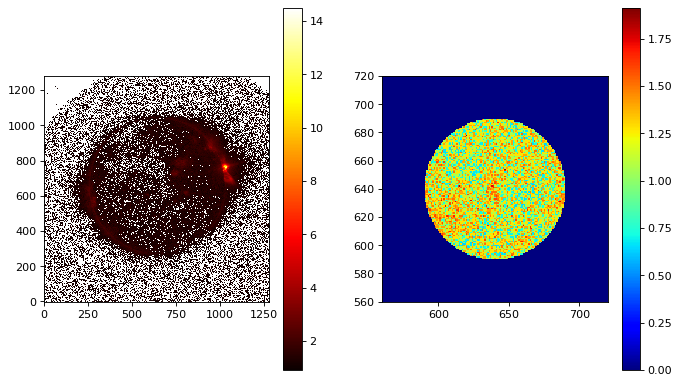

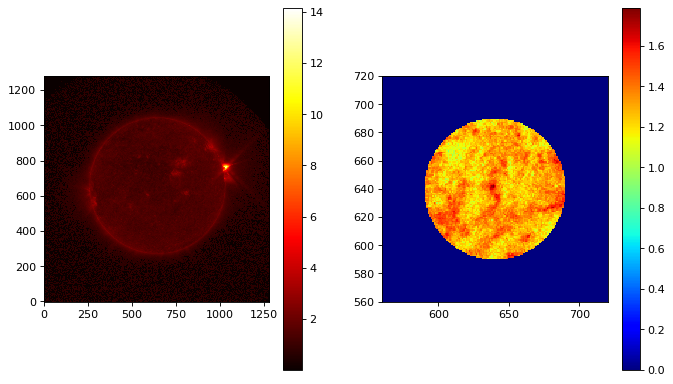

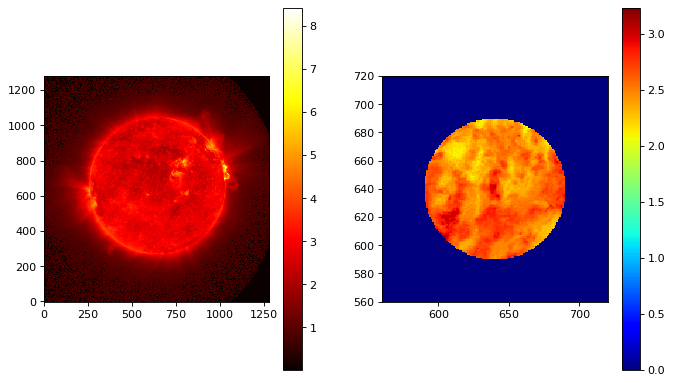

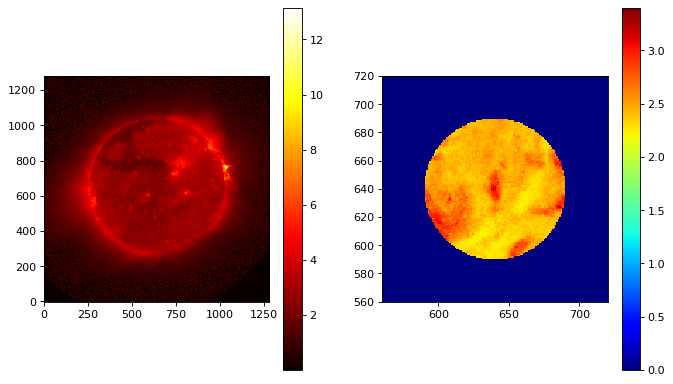

In [28]:
for ik in range(layer):
    fig = plt.figure(figsize=(10,6),dpi=80)
    ax1 = fig.add_subplot(121)
    cax1 = ax1.imshow(img[ik, :, :]**0.25, origin='lower', cmap='hot')
    ax2 = fig.add_subplot(122)
    cax2 = ax2.imshow(nimg[:, :, ik]**0.25, origin='lower', cmap='jet')
    #ax1.set_title('Observed {}'.format(fwvs[ik]))
    #ax2.set_title('Simulated {}'.format(fwvs[ik]))
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    #ax2.set_xticklabels([])
    #ax2.set_yticklabels([])
    ax2.set_xlim(wide/2-80,wide/2+80)
    ax2.set_ylim(wide/2-80,wide/2+80)
    fig.colorbar(cax1, ax = ax1)
    fig.colorbar(cax2, ax = ax2)
    plt.show()

In [16]:
#animate(em)